## Analyse the GAIA DR2 catalog (g>11) simulated on R22 with PhoSim...

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from IPython.display import IFrame, display, Markdown, HTML

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.OpdMetrology import OpdMetrology
from lsst.ts.phosim.Utility import getAoclcOutputPath, getConfigDir

import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection
import lsst.afw.display as afwDisplay
from lsst.geom import Extent2D, Point2D, SpherePoint
from lsst.geom import degrees as geomDeg


from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



In [7]:
dataDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/gMagGt11_'


These are the results of running GAIA DR2 with the following : 
    
    * camDimOffset is  -150
    * PhoSim added argPrepend is -w results_gaia/gMagGt11_ -s  "R22_S00|R22_S01|R22_S02|R22_S10|R22_S11|R22_S12|R22_S20|R22_S2
1|R22_S22|"

In [5]:
class calcMetrics():

    def loadZernikeData(self, opdZkFilePath, wfsZkFilePath):

        opdZkData = np.loadtxt(opdZkFilePath)
        wfsZkData = np.loadtxt(wfsZkFilePath)

        return opdZkData, wfsZkData


    def calcSSR(self, opdZkData, wfsZkData):

        zerDiffSqByField = np.sum((wfsZkData - opdZkData)**2, axis=1)
        zerDiffSqTotal = np.sum(zerDiffSqByField)

        return zerDiffSqByField, zerDiffSqTotal



In [8]:
# initialize metrics class 
calcMagMetrics = calcMetrics()

# initialize storage arrays 
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
    
opdZkFilePath = os.path.join(dataDir, 'opd.zer.gaia')
wfsZkFilePath = os.path.join(dataDir, 'wfs.zer.gaia')
opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
opdData = opdData[:3]
wfsData = wfsData[:3]
zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))


# calculate sum of squared residuals : 
# zerFieldSSR = np.sum((wfsZkData - opdZkData)**2, axis=1)
# zerTotalSSR = np.sum(zerFieldSSR)
zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
ssrFieldVals.append(zerFieldSSR)
ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))


In [14]:
opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
np.shape(opdData)

(9, 19)

In [17]:
from scipy import ndimage
from astropy.io import fits

# check out the individual OPD files per CCD : 

#topDir = 'results_gaia'
#expDir = 'gMagGt11_' 
baseOutputDir = dataDir # os.path.join(topDir,expDir)

iterDefaultDirName = "iter"
iterCount = 0
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)
outputImgDirName = "img"
        
outputImgDir = os.path.join(baseOutputDir, iterDirName,
                                        outputImgDirName)
opdDir = outputImgDir
print(opdDir)

opdFile= os.path.join(opdDir, 'opd_9006000_0.fits.gz') # for the first CCD 
opd = fits.getdata(opdFile)


/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/gMagGt11_/iter0/img


In [19]:
np.shape(opd)

(255, 255)

What does the opd file (for each CCD) represent ?  Why is the shape 255x255 ? 

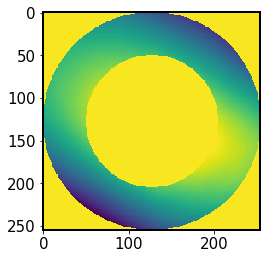

In [21]:
plt.imshow(opd)

That's what it looks like - is it one of the mirrors ? 

But this is the truth - can we split the wfs.zer  into magnitudes   ? 

In [22]:
a = [5.951526947731664574e-01, 5.900625321906480814e-01, 5.908693331351748679e-01, 5.933334074321401364e-01,
     5.853563245449867614e-01, 5.865871078970836816e-01,
 5.961024428613196369e-01, 5.881937914249429911e-01, 5.869626400064653637e-01]


In [23]:
np.mean(a)

0.5902911415851031

In [24]:
min(a)

0.5853563245449868

In [75]:
rafts = ['22']
chips  = ['00','01','02', 
          '10','11','12',
          '20','21','22']
sensors = ''
for r in rafts:
    for c in chips:
        s = "R%s_S%s|"%(r,c) 
        sensors += s 
sensors = ' "%s" '%sensors
sensors

' "R22_S00|R22_S01|R22_S02|R22_S10|R22_S11|R22_S12|R22_S20|R22_S21|R22_S22|" '

In [79]:
sensors = "R00_S22|R04_S20|R44_S00|R40_S02"
sensors = ' "%s" '%sensors
sensors

' "R00_S22|R04_S20|R44_S00|R40_S02" '

In [81]:
a = 2 

if a< 3 : print(a+4)

6


In [53]:
# Read in the Star Catalog 
from astropy.table import Table
accessDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
cat = Table.read(accessDir+'starCatGAIA_gt11.txt', format='ascii')

# Read in the postage image catalog
postage = Table.read(os.path.join(dataDir,'postagedonutStarsExtraIntra.txt'), format='ascii')


In [57]:
cat.colnames

['Id', 'Ra', 'Decl', 'Mag']

Text(0, 0.5, 'count')

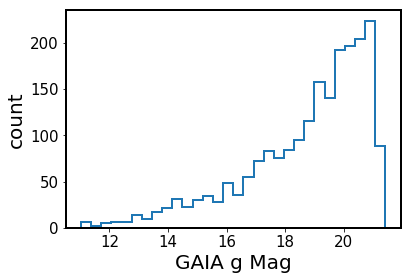

In [61]:
plt.hist(cat['Mag'], histtype='step',lw=2, bins=30)
plt.xlabel('GAIA g Mag')
plt.ylabel('count')

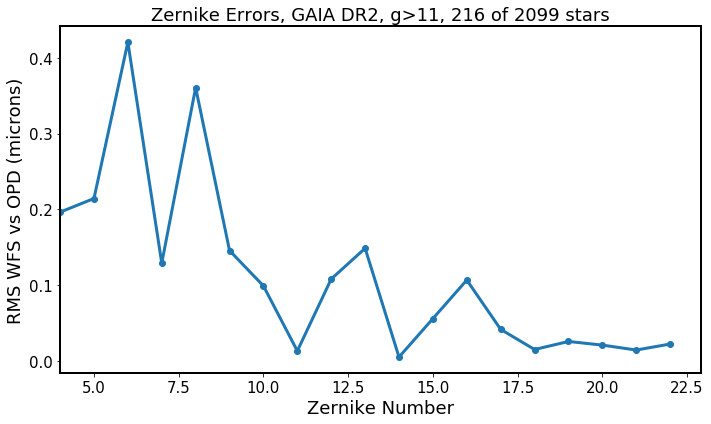

In [67]:
# Print Zernikes comparison of WFS to OPD 

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, 0]), 
         '-o', lw=3, label='')
ax.set_xlim(4.)
ax.set_xlabel('Zernike Number', size=18)
ax.set_ylabel('RMS WFS vs OPD (microns)', size=18)
ax.set_title('Zernike Errors, GAIA DR2, g>11, %d of %d stars'%(len(postage),len(cat)), size=18)


plt.tight_layout()


In [42]:
# Read in the postISR image using the Butler 

focalType = 'extra'  # choose whether extra or intra focal image
obsIdDic = {'intra':9006001,  'extra':9006002} 
obsId = obsIdDic[focalType]

detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R22'
detector = 'S00'

sensor = raft+'_'+detector 

detNumDict = {'S00':90, 'S01':91, 'S02':92, 'S10':93, 'S11':94, 'S12':95, 'S20':96, 'S21':97, 'S22':98}
detNum = detNumDict[detector]

data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 'detectorName': detector, 'detector': detNum}


# Read each figure as a postage stamp, store data to an array 
images = {}

print('\nReading data from')
print(dataDir)
repo_dir = os.path.join(dataDir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

# show what keys are needed by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int, 'filter': str,'raftName': str, 'detectorName': str, 'detector': int}
post = butler.get('postISRCCD', **data_id) 

# store in a dictionary
images[sensor] = post.image.array

    


Reading data from
/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/gMagGt11_


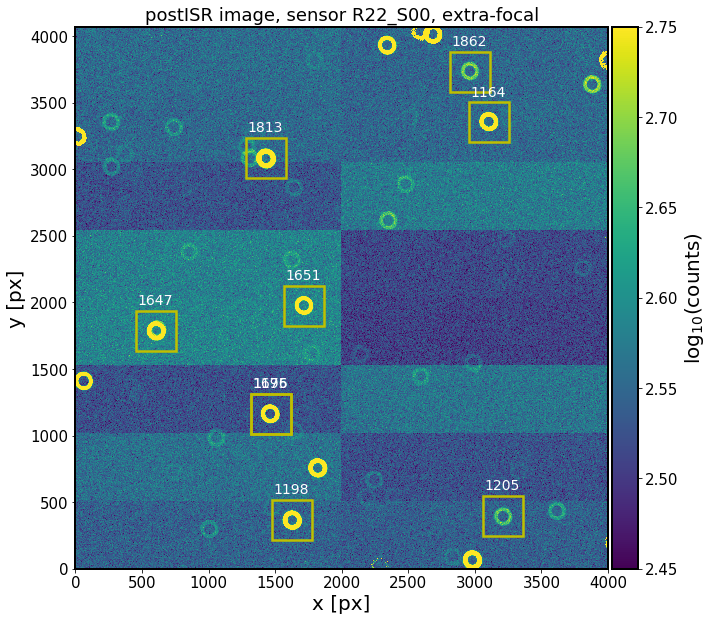

In [73]:
# print the entire CCD R22_S01 postISR image data

    
# helper funtion for the colorbar 
# from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar



fig, ax = plt.subplots(1,1,figsize=(10,10))

# plot the postage stamp
img = ax.imshow(np.log10(images[sensor].T), vmin = 2.45, vmax=2.75,
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('postISR image, sensor %s, %s-focal'%(sensor,focalType))

m1 = postage['abbrevDetectorName'] == sensor
m2 = postage['focalPlane'] == focalType
mask = m1 * m2 
for i in range(len(postage[mask])):
    x,y = postage[mask]['xpos'][i], postage[mask]['ypos'][i]
    starId = postage[mask]['starId'][i]
    ax.plot(x,y, 's', markersize=40, markerfacecolor='none',
             markeredgewidth=2.5, markeredgecolor='y')
    ax.text(x-140, y+200, starId, fontsize=14, color='white')
plt.tight_layout()


abbrevDetectorName,focalPlane,starId,xpos,ypos
str7,str5,int64,float64,float64
R22_S00,extra,1164,3107.0,3351.0
R22_S00,extra,1176,1468.0,1163.0
R22_S00,extra,1198,1628.0,363.0
R22_S00,extra,1205,3214.0,394.0
R22_S00,extra,1647,608.0,1782.0
R22_S00,extra,1651,1720.0,1972.0
R22_S00,extra,1695,1468.0,1163.0
R22_S00,extra,1813,1435.0,3081.0
R22_S00,extra,1862,2962.507806,3731.674548
